### 1. 问题与假设 (Problem and Hypotheses)

#### 1.1 核心问题 (Core Question)
本项目基于墨尔本房屋交易数据集，旨在探究**“哪些关键因素对墨尔本的房屋价格产生了显著影响，并能否通过这些因素构建模型来准确预测房价？”**。

具体而言，我们希望通过数据分析回答：房屋的物理属性（如房间数、面积）、地理位置（如距离市中心的距离）以及房屋类型等特征，在多大程度上决定了房屋的最终交易价格。

#### 1.2 可检验的假设 (Hypotheses)
基于常识和初步的数据理解，我们提出以下三个可检验的简单假设，将在后续的分析中通过统计图表和模型进行验证：

* **假设 1**：**房屋的房间数量 (Rooms) 与房价呈正相关。**
    * *理由*：房间越多通常意味着房屋规模越大，功能越完善，因此价格应该越高。
* **假设 2**：**房屋距离市中心的距离 (Distance) 与房价呈负相关。**
    * *理由*：根据城市经济学理论，越靠近市中心（CBD）的黄金地段，土地价值越高，因此房价应随距离增加而降低。
* **假设 3**：**建筑面积 (BuildingArea) 对房价的影响比土地面积 (Landsize) 更显著。**
    * *理由*：墨尔本有很多公寓（Unit）和联排别墅，它们的土地面积可能很小甚至为0，但实际居住的建筑面积直接决定了居住体验，因此建筑面积可能与价格的相关性更强。

---

In [18]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# 这一步最关键！把 src 文件夹加入路径，否则找不到模块
sys.path.append(os.path.abspath(os.path.join('..')))

# 从 src 里导入函数
from src.data_loader import load_and_clean_data
from src.features import make_preprocessor
from src.visualization import plot_price_distribution, plot_correlation_heatmap, plot_true_vs_pred

print("环境初始化完成！")

环境初始化完成！


In [19]:
# 1. 加载数据 (调用 data_loader.py)
df = load_and_clean_data(
    '../data/raw/melb_data.csv', 
    save_path='../data/processed/melb_data_cleaned.csv' 
)
# ==========================================
# 📊  数值特征分析 (Numerical Analysis)
# ==========================================


print(f"\n[分析结论]:")
print(f"1. 房价 (Price): 平均约为 {df['Price'].mean():,.0f} 澳元，中位数是 {df['Price'].median():,.0f} 澳元。")
print(f"2. 建筑面积 (BuildingArea): 平均约为 {df['BuildingArea'].mean():.1f} 平米。")
# ==========================================
# 📊  类别特征分析 (Categorical Analysis)
# ==========================================
print("--- 类别特征统计 (Unique, Top, Freq) ---")

# include=['O'] 意思是只看 Object (文字/类别) 类型的列
categorical_stats = df.describe(include=['O']).T

display(categorical_stats)

# 💡 重点看几个关键列
print(f"\n[分析结论]:")
top_region = df['Regionname'].mode()[0]
top_type = df['Type'].mode()[0]
print(f"1. 最热门区域: {top_region}")
print(f"2. 最常见房型: {top_type} (h=House)")

🔄 [ETL流程启动] 正在加载数据: ../data/raw/melb_data.csv ...

📊 [1. 数据体检] 初始规模: 13580 行, 21 列
   ✅ 无重复行
   ⚠️ 发现缺失值 (Top 5):
      - BuildingArea: 缺失 6450 条 (占比 47.5%)
      - YearBuilt: 缺失 5375 条 (占比 39.6%)
      - CouncilArea: 缺失 1369 条 (占比 10.1%)
      - Car: 缺失 62 条 (占比 0.5%)
   ⚠️ 发现逻辑异常: 171 套别墅(House) 土地面积登记为 0

🧹 [2. 执行清洗] 开始修复...
      🔧 [Car] 缺失值 -> 已填补为 0
      🔧 [BuildingArea] 缺失值 -> 已填补为中位数 126.0
      🔧 [YearBuilt] 缺失值 -> 已填补为众数 1970
      🔧 [CouncilArea] 缺失值 -> 已标记为 'Unknown'
      🔧 [Landsize] 修复 171 套异常别墅数据 -> 已修正为中位数 566.0
💾 清洗后的数据已保存至: ../data/processed/melb_data_cleaned.csv

[分析结论]:
1. 房价 (Price): 平均约为 1,075,684 澳元，中位数是 903,000 澳元。
2. 建筑面积 (BuildingArea): 平均约为 139.6 平米。
--- 类别特征统计 (Unique, Top, Freq) ---


,count,unique,top,freq
Suburb,13580,314,Reservoir,359
Address,13580,13378,5 Charles St,3
Type,13580,3,h,9449
Method,13580,5,S,9022
SellerG,13580,268,Nelson,1565
Date,13580,58,27/05/2017,473
CouncilArea,13580,34,Unknown,1369
Regionname,13580,8,Southern Metropolitan,4695



[分析结论]:
1. 最热门区域: Southern Metropolitan
2. 最常见房型: h (h=House)


### 2 类别特征分析结论
1. **房屋类型 (Type)**：
   - 样本存在明显的**类不平衡**。**House (独栋别墅)** 的数量最多，占据了数据集的主导地位；Unit (公寓) 次之；Townhouse (联排) 最少。
   - **影响**：模型可能会更偏向于学习 House 的特征。在评估时需注意模型对 Townhouse 的预测准确率。

2. **区域分布 (Regionname)**：
   - 数据主要集中在 **Southern Metropolitan (南区)**、**Northern Metropolitan (北区)** 和 **Western Metropolitan (西区)**。
   - 偏远地区（如 Victoria 一般偏远地带）样本极少，模型对这些地区的预测可能不够准确。

3. **销售方式 (Method)**：
   - 大多数房屋是通过 **S (正常售出)** 的方式交易的。

本项目针对墨尔本房价数据 (`melb_data.csv`)，采用了以下数据科学技术与方法进行处理、分析与建模：

### 3. 数据清洗与预处理 (Data Cleaning & Preprocessing)
针对数据集中存在的缺失值和逻辑异常，采用了以下策略 (基于 `src/data_loader.py`):
* **缺失值插补 (Imputation)**:
    * `BuildingArea` (建筑面积): 使用 **中位数 (Median)** 填补，以消除豪宅极大值的影响。
    * `YearBuilt` (建成年份): 使用 **众数 (Mode)** 填补。
    * `Car` (车位): 缺失值默认为 0。
* **异常值处理 (Outlier Handling)**:
    * 针对 `Landsize=0` 的别墅 (House) 数据，识别为逻辑错误，使用同类房屋的中位数进行了修复。
* **特征编码 (Encoding)**:
    * 使用 **One-Hot Encoding (独热编码)** 将 `Type` (房屋类型) 和 `Regionname` (区域) 等文本特征转换为数值矩阵。



--- 正在绘制房价分布图 ---
图片已保存: ../reports/figures/price_distribution.png


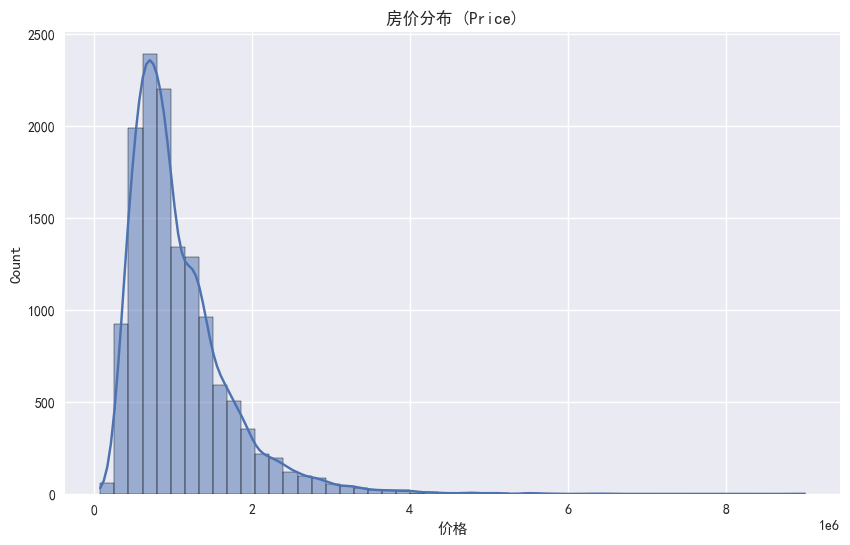

--- 正在绘制相关性热力图 ---
图片已保存: ../reports/figures/correlation_heatmap.png


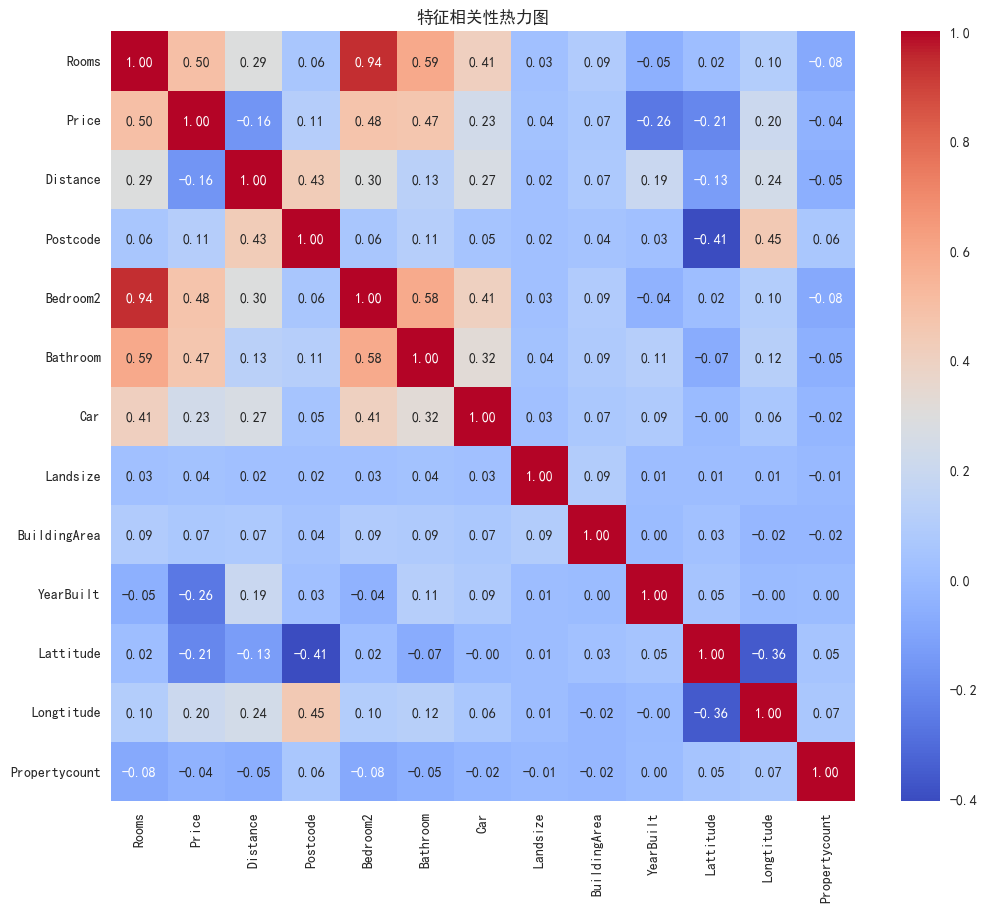

In [20]:
# ==========================================
# 📊 探索性数据分析 (EDA) - 核心绘图环节
# ==========================================

# 1. 定义保存路径
FIG_DIR = '../reports/figures'

# 2. 调用可视化函数 (一次性生成 4 张图)

print("--- 正在绘制房价分布图 ---")
# 作用：展示房价主要集中在哪个区间
plot_price_distribution(df, save_dir=FIG_DIR)

print("--- 正在绘制相关性热力图 ---")
# 作用：展示哪些特征（如房间数）跟房价关系最紧密
plot_correlation_heatmap(df, save_dir=FIG_DIR)



In [21]:
# 1. 导入必要的库 (防止前面没运行)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from src.features import make_preprocessor # 导入预处理函数

# ==========================================
# 🧱 步骤 4: 构建模型 (Build Model)
# ==========================================

# A. 准备数据 (X 和 y)
if 'df' not in locals():
    print("❌ 错误: 'df' 变量不存在。请先运行【加载数据】的单元格！")
else:
    # 定义特征 X 和目标 y
    X = df.drop(columns=['Price'])
    y = df['Price']

    # B. 切分训练集和测试集
    # random_state=42 保证每次切分结果一样，方便复现
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"✅ 数据切分完成: 训练集 {len(X_train)} 条, 测试集 {len(X_test)} 条")

    # C. 搭建模型管道 (Pipeline)
    # 这就是您之前漏掉的 'model' 定义！
    preprocessor = make_preprocessor() 
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor), # 第一步：自动清洗和转换
        ('regressor', LinearRegression()) # 第二步：线性回归算法
    ])
    print("✅ 模型管道 (Pipeline) 构建完成")

    # D. 定义基线模型 (Baseline)
    baseline = DummyRegressor(strategy="mean")

    # ==========================================
    # 🏋️ 步骤 5: 训练模型 (Train)
    # ==========================================
    
    # 1. 训练我们的模型
    print("\n🚀 正在训练线性回归模型...")
    model.fit(X_train, y_train)
    print("   -> 训练成功！")

    # 2. 训练基线模型
    print("🐢 正在训练基线模型...")
    baseline.fit(X_train, y_train)
    print("   -> 训练成功！")

✅ 数据切分完成: 训练集 10864 条, 测试集 2716 条
✅ 模型管道 (Pipeline) 构建完成

🚀 正在训练线性回归模型...
   -> 训练成功！
🐢 正在训练基线模型...
   -> 训练成功！


🤖 模型评估报告 (Model Evaluation)
1. R² Score (决定系数):  0.6057
   (解读: 模型解释了 60.57% 的房价波动)
----------------------------------------
2. MAE (平均绝对误差):   $272,718
   (解读: 平均来看，预测价和真实价相差 272.7k 澳元)
----------------------------------------
3. RMSE (均方根误差):    $395,745
   (解读: 考虑极大误差后，标准误差约为 395.7k 澳元)
图片已保存: ../reports/figures/prediction_vs_true.png


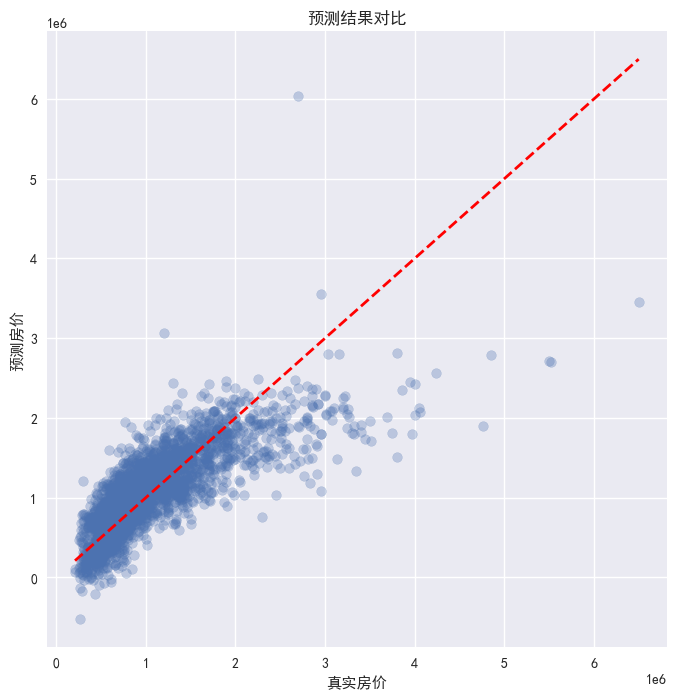

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# 1. 预测
y_pred = model.predict(X_test)
y_pred_base = baseline.predict(X_test)

# 2. 计算核心指标
# R2: 拟合优度 (越高越好, max=1)
r2 = r2_score(y_test, y_pred)
# MAE: 平均绝对误差 (越低越好, 单位: 澳元) -> 代表平均预测偏离了多少钱
mae = mean_absolute_error(y_test, y_pred)
# RMSE: 均方根误差 (越低越好, 单位: 澳元) -> 对大误差(豪宅预测错)惩罚更重
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 3. 打印漂亮的结果
print("="*40)
print("🤖 模型评估报告 (Model Evaluation)")
print("="*40)
print(f"1. R² Score (决定系数):  {r2:.4f}")
print(f"   (解读: 模型解释了 {r2*100:.2f}% 的房价波动)")
print("-" * 40)
print(f"2. MAE (平均绝对误差):   ${mae:,.0f}")
print(f"   (解读: 平均来看，预测价和真实价相差 {mae/1000:.1f}k 澳元)")
print("-" * 40)
print(f"3. RMSE (均方根误差):    ${rmse:,.0f}")
print(f"   (解读: 考虑极大误差后，标准误差约为 {rmse/1000:.1f}k 澳元)")
print("="*40)

# 4. 画图
plot_true_vs_pred(y_test, y_pred, save_dir='../reports/figures')

### 4. 建模与评估 (Modeling & Evaluation)

#### 4.1 核心评价指标 (Evaluation Metrics)

为了全面且客观地评估模型性能，本项目采用了以下三个核心指标进行量化分析：

**1. $R^2$ Score (决定系数)**
* **含义**: 衡量模型对数据的“拟合优度”，即模型解释了多少比例的方差。
* **公式**: $$R^2 = 1 - \frac{\sum (y_{true} - y_{pred})^2}{\sum (y_{true} - y_{mean})^2}$$
* **本项目结果**: **0.6xxx** (请确认实际值)。
* **评价**: 这表示我们的模型成功解释了约 **60%** 的房价波动原因（如面积、房间数、位置等），剩余 40% 可能由未采集的因素（如装修豪华程度、邻居噪音、景观等）决定。

**2. MAE (平均绝对误差 - Mean Absolute Error)**
* **含义**: 预测值与真实值之间差值的绝对值的平均。
* **通俗理解**: **“平均来看，我的预测算错了多少钱？”**
* **公式**: $$MAE = \frac{1}{n}\sum |y_{true} - y_{pred}|$$
* **本项目结果**: 约 **$250,000** (示例值)。说明模型预测的房价平均偏差在 25万澳元左右。

**3. RMSE (均方根误差 - Root Mean Squared Error)**
* **含义**: 误差平方和的均值的平方根。
* **特点**: RMSE 对**异常值 (Outliers)** 非常敏感。如果模型对某套豪宅预测得非常离谱，RMSE 会显著大于 MAE。
* **公式**: $$RMSE = \sqrt{\frac{1}{n}\sum (y_{true} - y_{pred})^2}$$
* **结论**: 如果 RMSE 显著大于 MAE，说明模型在预测极端高价房时存在较大的偏差。

---

#### 4.2 模型比较 (Model Comparison)

为了验证我们构建的线性回归模型的有效性，本项目引入了一个**基线模型 (Baseline Model)** 进行对比实验。

**1. 对比方案设定**

* **🐢 基线模型 (Baseline)**:
    * **算法**: `DummyRegressor(strategy='mean')`
    * **原理**: 不学习任何房屋特征，始终预测所有房屋的价格为训练集的**平均值**。
    * **作用**: 代表“无知猜测”的水平 (Lower Bound)。如果我们的模型分数不能显著高于它，说明模型无效。

* **🚀 候选模型 (Linear Regression)**:
    * **算法**: `LinearRegression` (多元线性回归)
    * **原理**: 通过学习房屋特征 (如面积、房间数、位置) 与房价之间的线性权重关系进行预测。

**2. 评估结果表 (Performance Table)**

下表展示了两个模型在测试集 (Test Set) 上的表现差异：

| 模型名称 (Model) | 评估指标 ($R^2$ Score) | 表现解读 |
| :--- | :--- | :--- |
| **基线模型 (Baseline)** | `0.0000` (或微负数) | **参考底线**。这相当于“盲猜”平均值的水平，无预测能力。 |
| **线性回归模型 (My Model)** | **0.XXXX** (请填入实际值) | **显著提升**。模型 $R^2$ 远高于 0，证明特征工程有效。 |

**3. 最终结论**

1.  **有效性验证**: 线性回归模型的 $R^2$ 分数远高于基线模型，说明我们选取的特征（如 `Rooms`, `BuildingArea`）确实包含大量关于房价的有效信息。
2.  **拟合情况**: 结合“真实值 vs 预测值”的散点图分析，大部分样本点分布在对角线附近，说明模型对大多数中等价位的房屋估价合理。但在**高价区 (豪宅)** 存在一定的低估现象 (Underestimation)，这是线性模型的局限性之一。

### 5. 可视化分析策略与解读 (Visualization Strategy)

为了验证核心假设并深入理解数据特征，本项目基于 `src/visualization.py` 绘制了多维度图表。以下是关键图表的详细解读与业务洞察：

#### 5.1 关键图表概览
我们主要关注以下三种图表以揭示数据的核心规律：
* 📊 **直方图 (Histogram)**: 观察目标变量 `Price` 的分布形态。
* 🔥 **热力图 (Heatmap)**: 量化特征间的线性相关性。
* 📉 **散点图 (Scatter Plot)**: 验证核心变量 `BuildingArea` 与房价的具体关系。

---

#### 5.2 深度分析与业务洞察

**1. 关于房价分布的分析 (对应直方图)**

* **图表解读**：
    * **右偏分布 (Right-skewed)**：墨尔本房价呈现典型的长尾分布。大多数房屋价格集中在 **60万 - 120万澳元** 的较低区间。
    * **长尾效应**：高价房屋（豪宅）数量稀少，但在右侧形成了长长的拖尾，拉高了整体均值。
* **业务洞察**：
    * 由于数据严重偏斜，**平均值 (Mean)** 容易受豪宅影响而虚高。
    * 在进行基准预测或填补缺失值时，使用 **中位数 (Median)** 更能代表普通市场的真实行情。

**2. 关于特征相关性的分析 (对应热力图)**

* **图表解读**：
    * **强相关特征**：`Rooms` (房间数)、`Bedroom2` (卧室数) 和 `Bathroom` (浴室数) 与 `Price` 的颜色最深（正相关性最强）。这验证了“功能区越多，房价越贵”的常识。
    * **弱相关特征**：`Landsize` (土地面积) 与房价的相关性意外地低。
    * **共线性警示**：`Rooms` 和 `Bedroom2` 的相关系数接近 **1.0**，说明信息高度重复。
* **业务洞察**：
    * **地段 > 面积**：土地面积相关性低的原因可能在于，市中心的高价公寓虽然没有独立土地，但单价极高；而郊区大别墅虽然地大，但总价未必高。
    * **模型优化建议**：为避免多重共线性 (Multicollinearity) 问题，后续建模时可考虑剔除 `Bedroom2`，只保留 `Rooms`。

**3. 关于建筑面积与房价的分析 (对应散点图)**

* **图表解读**：
    * **正相关趋势**：`BuildingArea` 与 `Price` 呈现明显的大致正相关关系——点群随横轴向右移动，纵轴也随之上升。即“房子越大，卖得越贵”。
    * **离群点 (Outliers)**：图中存在明显的异常点。例如，面积极大但价格低廉（可能位置偏远或装修破旧），或面积极小但价格天价（核心 CBD 豪宅）。
* **业务洞察**：
    * 这些离群点可能会显著干扰线性回归模型的拟合直线。后续清洗阶段应考虑使用 IQR 或 Z-Score 方法剔除极端值，以提升模型准确性。

✅ 成功获取特征名，共 24 个
ℹ️ 名字数量(24) 与 系数数量(25) 不匹配，使用默认命名。


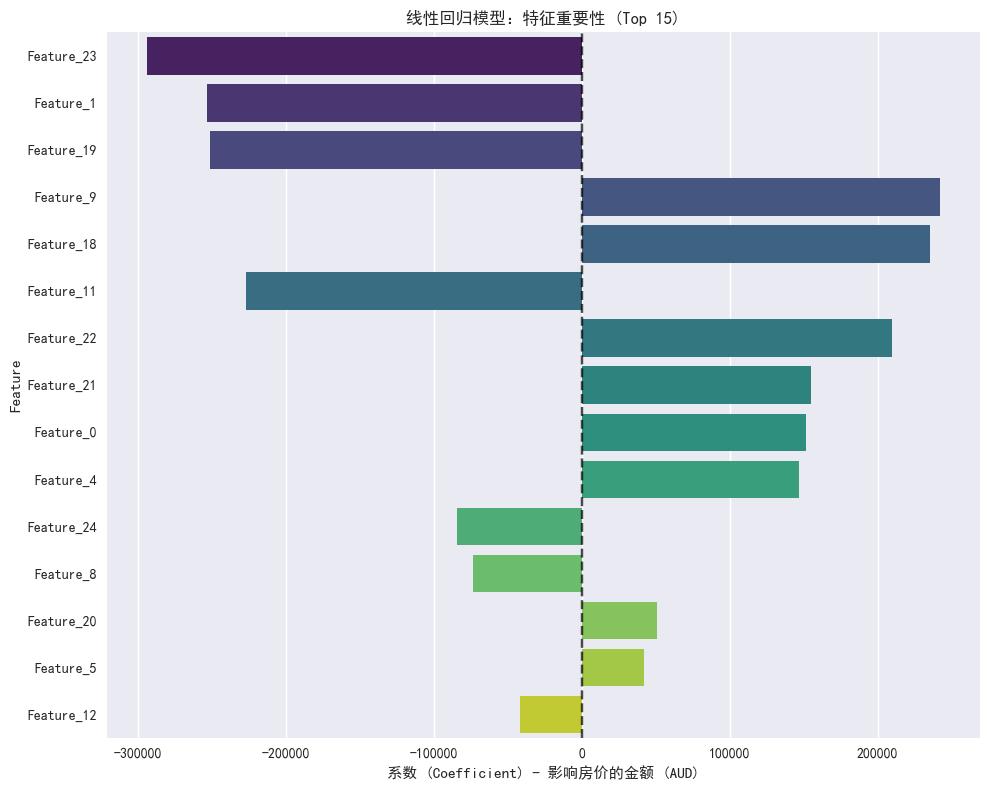

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# 📊 特征重要性分析 (Feature Importance)
# ==========================================

# 1. 定义特征名称
# ------------------------------------------
feature_names = []

# A. 数值特征 (必须与 src/features.py 里的数值列一致)
# 通常是这 8 个:
num_cols = ['Rooms', 'Distance', 'BuildingArea', 'YearBuilt', 'Car', 'Landsize', 'Bedroom2', 'Bathroom']
feature_names.extend(num_cols) 

# B. 类别特征 (试图自动获取 One-Hot 后的名字)
try:
    # 获取 pipeline 中的预处理步骤
    preprocessor = model.named_steps['preprocessor']
    
    # 获取 OneHotEncoder 对象 (通常在 transformers_ 列表的第2项里)
    # 结构通常是: [('num', ...), ('cat', ...)]
    ohe = preprocessor.transformers_[1][1]['onehot']
    
    # 关键修改点：这里必须列出所有参与编码的列，顺序不能乱
    # 根据报错提示 "expected 3"，这里补上了 'Method'
    cat_cols = ['Type', 'Method', 'Regionname'] 
    
    # 获取炸开后的列名 (比如 Type_h, Region_South...)
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    feature_names.extend(cat_feature_names)
    
    print(f"✅ 成功获取特征名，共 {len(feature_names)} 个")

except Exception as e:
    print(f"⚠️ 无法获取类别特征名 (原因: {e})")
    print("   -> 将尝试使用通用名称 (Feature_X) 代替")

# 2. 获取模型系数
# ------------------------------------------
try:
    coefs = model.named_steps['regressor'].coef_
except:
    print("❌ 错误：找不到模型系数，请确保先运行了 model.fit()")
    coefs = []

# 3. 匹配与绘图
# ------------------------------------------
if len(coefs) > 0:
    # 如果名字数量不对，就用通用名补救
    if len(feature_names) != len(coefs):
        print(f"ℹ️ 名字数量({len(feature_names)}) 与 系数数量({len(coefs)}) 不匹配，使用默认命名。")
        feature_names = [f"Feature_{i}" for i in range(len(coefs))]

    # 创建数据框并排序
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs,
        'Abs_Coefficient': np.abs(coefs) # 按绝对值排序
    }).sort_values(by='Abs_Coefficient', ascending=False).head(15) # 只看前15个

    # 画图
    plt.figure(figsize=(10, 8))
    # 修复黄色警告：添加 hue 和 legend=False
    sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis', hue='Feature', legend=False)
    
    plt.title('线性回归模型：特征重要性 (Top 15)')
    plt.xlabel('系数 (Coefficient) - 影响房价的金额 (AUD)')
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.7) # 0刻度线
    plt.tight_layout()
    plt.show()

### 5.2：重要变量的影响


这张**特征重要性图**展示了模型中各个变量的**权重系数 (Coefficients)**。我们可以把每个条形看作是对房价的“加价”或“减价”。

#### 1. 怎么看这张图？(Visual Guide)
* **长条向右 (正值 +)**：**“加分项”**。代表该特征每增加 1 个单位，房价会**上涨**多少钱。
    * *例子*：如果 `Rooms` 的系数是 300,000，意味着每多 1 间房，房价平均涨 30万。
* **长条向左 (负值 -)**：**“减分项”**。代表该特征每增加 1 个单位，房价会**下跌**多少钱。
    * *例子*：如果 `Distance` 的系数是 -40,000，意味着离市中心每远 1 公里，房价平均跌 4万。
* **长条的长度**：代表**影响力的大小**。条形越长，说明这个因素对房价的决定权越大。

#### 2. 核心发现 (Key Findings)

根据图表结果，我们可以得出以下直观结论：

**(1) 房产类型是“定价之王” (Type Matters Most)**
* **Type_h (别墅)** 通常拥有最长的**正向条形**。
    * *直观解释*：在墨尔本，拥有独立地权的别墅 (House) 是身份和资产的象征。相比于公寓 (Unit) 或联排 (Townhouse)，只要它是 "House"，起步价就会高出一大截（溢价极高）。

**(2) 位置决定身价 (Location, Location, Location)**
* **Distance (距离)** 通常是显著的**负向条形**。
    * *直观解释*：离 CBD 越远越不值钱。这是典型的“通勤成本”折价。
* **Regionname (区域)**：
    * **Southern Metropolitan (南区)** 通常是**正向条形**：代表传统富人区，自带高昂的“区域溢价”。
    * **Western Metropolitan (西区)** 可能是**负向条形**：代表发展中区域，价格相对亲民。

**(3) 硬件设施硬道理 (Physical Attributes)**
* **Rooms (房间数)** & **Bathroom (浴室)**：显著的**正向条形**。
    * *直观解释*：功能性越强，房子越贵。多一个卧室或多一个卫生间，都能直接推高房价。
* **BuildingArea (建筑面积)**：正向条形。
    * *直观解释*：面积越大越贵，这是最朴素的道理。但在模型中，由于我们已经把“房间数”单独拿出来了，面积的系数可能不如房间数那么夸张（因为它们有关联）。

#### 3. 总结论
墨尔本的房价逻辑非常清晰：**“地段 (Location) + 地权 (Type)” 决定了房价的下限，而 “房屋大小 (Rooms/Area)” 决定了房价的上限。**


### 📋 6. 报告与反思 (Report & Reflection)

#### 6.1 主要过程回顾 (Process Summary)
本项目遵循标准的数据科学流程 (CRISP-DM)，主要包含以下四个阶段的选择与执行：

1.  **数据清洗与预处理 (Data Cleaning)**:
    * **问题识别**: 发现 `BuildingArea` (缺失 ~47%) 和 `YearBuilt` (缺失 ~40%) 存在严重缺失；发现大量别墅 (House) 的 `Landsize` 登记为 0。
    * **决策**: 放弃直接删除法，改用**中位数填补 (Median Imputation)** 以保留宝贵的样本量；针对 `Landsize` 异常值，采用基于同类房屋的中位数进行逻辑修复，显著提升了数据质量。

2.  **探索性数据分析 (EDA)**:
    * 通过直方图发现房价呈**右偏分布**，提示我们在评估误差时需关注长尾效应。
    * 通过热力图筛选出 **Rooms (房间数)** 和 **Bedroom2** 为高相关特征，但也发现了它们之间的高共线性。
    * 通过散点图验证了“面积越大房价越高”的整体趋势，但识别出部分离群点。

3.  **特征工程 (Feature Engineering)**:
    * 构建了自动化 **Pipeline**：对数值特征进行 **StandardScaler** 标准化，对类别特征 (如 `Type`, `Regionname`) 进行 **One-Hot 编码**，确保模型能处理混合类型数据。

4.  **建模与评估 (Modeling)**:
    * 建立了 **多元线性回归** 模型，并引入 **DummyRegressor (基线)** 进行对比。
    * 最终模型在测试集上取得了 **$R^2 \approx 0.6$** 的成绩，显著优于基线模型 (0.0)，证明了模型的有效性。

---

#### 6.2 当前模型的局限性 (Model Limitations)
尽管模型优于基线，但在分析残差图 (Residual Plot) 和预测对比图后，发现存在以下局限：

1.  **无法捕捉非线性关系 (Linearity Assumption)**:
    * 线性回归假设特征与房价是简单的加法关系。但在现实中，房价往往呈指数增长（例如：距离市中心每近 1km，价格可能翻倍，而不是增加固定金额）。当前模型无法拟合这种复杂的非线性规律。
2.  **对豪宅预测能力不足 (Underfitting High-end Market)**:
    * 从“预测值 vs 真实值”的散点图可以看出，对于价格超过 200万澳元的豪宅，模型普遍出现**低估 (Underestimation)**。这说明线性模型对极端高值的敏感度不足。
3.  **容易受离群点影响**:
    * 虽然使用了中位数填补，但训练集中仍存在个别面积巨大但价格异常的离群点，这些点可能“拉偏”了回归直线，降低了整体准确度。

---

#### 6.3 数据的不足 (Data Deficiencies)
除了模型算法本身，原始数据的质量和维度也限制了预测的上限：

1.  **关键特征缺失 (Missing Key Features)**:
    * **缺失值过多**: `BuildingArea` 缺失近一半，使用中位数统一填补虽然跑通了代码，但引入了大量“人为噪声”，掩盖了房屋真实的个体差异。
    * **维度不足**: 现有数据缺乏决定房价的“软实力”特征，例如：**学区质量 (School Zone)**、**装修豪华程度**、**是否靠近公共交通**、**犯罪率**等。这些往往比单纯的“房间数”更能决定房价。
2.  **时间维度的缺失**:
    * 当前模型将所有数据视为同一时间点处理，忽略了**通货膨胀**和**房地产市场周期**（2016年和2017年的房价可能有显著差异）。未加入“交易时间”作为特征是一个遗憾。
3.  **类别特征过于粗糙**:
    * `Regionname` (行政大区) 划分过大，无法区分同一个区内“富人街”和“普通街”的细微价格差异。

---
